In [1]:
import pandas as pd
import numpy as np
import warnings 
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from skimage import exposure
from scipy.ndimage import median_filter
import os
import shutil
import random
import splitfolders
from shutil import copyfile
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Activation, Add
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import kerastuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop
import datetime, time

C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_32904\1853304758.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
warnings.filterwarnings('ignore')

In [3]:
def remove_all_files_and_directories(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The directory '{directory}' does not exist.")
        return

    # Remove all files in the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

    # Remove all subdirectories in the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

    # Remove the top-level directory itself
    os.rmdir(directory)

# 1. Chargement et prétraitement des images

## 1.1 Prétraitement d'image

In [4]:
# Function de prétraitement d'images
def pretraitement_image(img):    
    
    # 2) auto Contraste: ajuster automatiquement le contraste d'une image pour étendre 
    # la gamme de valeurs de pixel sur toute l'échelle des couleurs. (hist plus large)

    # Calculer les valeurs minimales et maximales des pixels de l'image
    min_value = tf.reduce_min(img)
    max_value = tf.reduce_max(img)
    # Appliquer la transformation linéaire pour ajuster automatiquement le contraste
    img = (img - min_value) * (255.0 / (max_value - min_value))
    # Convertir les valeurs des pixels en type uint8 (entiers non signés sur 8 bits)
    img = tf.cast(img, tf.uint8)
    
    # 3) Equalization :améliorer la répartition des intensités de pixels dans une image (hist plus plat)
#    img = exposure.equalize_hist(img)
    img = tfa.image.equalize(img)

    # 4) Débruitage (ajouter du bruit gaussien et supprimer le bruit par filtrage)
    img = img + 0.1 * np.random.randn(*img.shape)
    img = median_filter(img, size=(3, 3, 3))

    # 1) Whitening (blanchiment) : Normalisation des valeurs de pixels avec centarge et la mise en echelle
    img = (img - np.mean(img)) / np.std(img)
    return img

Un example de pretraitement d'image

In [5]:
# Charger une image (vous pouvez remplacer cette étape par le chargement de votre propre image)
image_path = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images/n02086079-Pekinese/n02086079_606.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)

# Cropping
cropped_image = image[50:150, 50:150]

# Whitening (blanchiment)
whitened_image = (image - np.mean(image)) / np.std(image)

# Contraste
# Calculer les valeurs minimales et maximales des pixels de l'image
min_value = tf.reduce_min(image)
max_value = tf.reduce_max(image)

# Appliquer la transformation linéaire pour ajuster automatiquement le contraste
autocontrasted_image = (image - min_value) * (255.0 / (max_value - min_value))

# Convertir les valeurs des pixels en type uint8 (entiers non signés sur 8 bits)
autocontrasted_image = tf.cast(autocontrasted_image, tf.uint8)

contrast_factor = 1.5
contrasted_image = tf.image.adjust_contrast(image, contrast_factor)
# Égalisation : améliorer la répartition des intensités de pixels dans une image

equalized_image = tfa.image.equalize(image)

# Débruitage (ajouter du bruit gaussien et supprimer le bruit par filtrage)
noisy_image = image + 0.1 * np.random.randn(*image.shape)
denoised_image = median_filter(noisy_image, size=(3, 3, 3))

# Redimensionnement
processed_image = pretraitement_image(image)


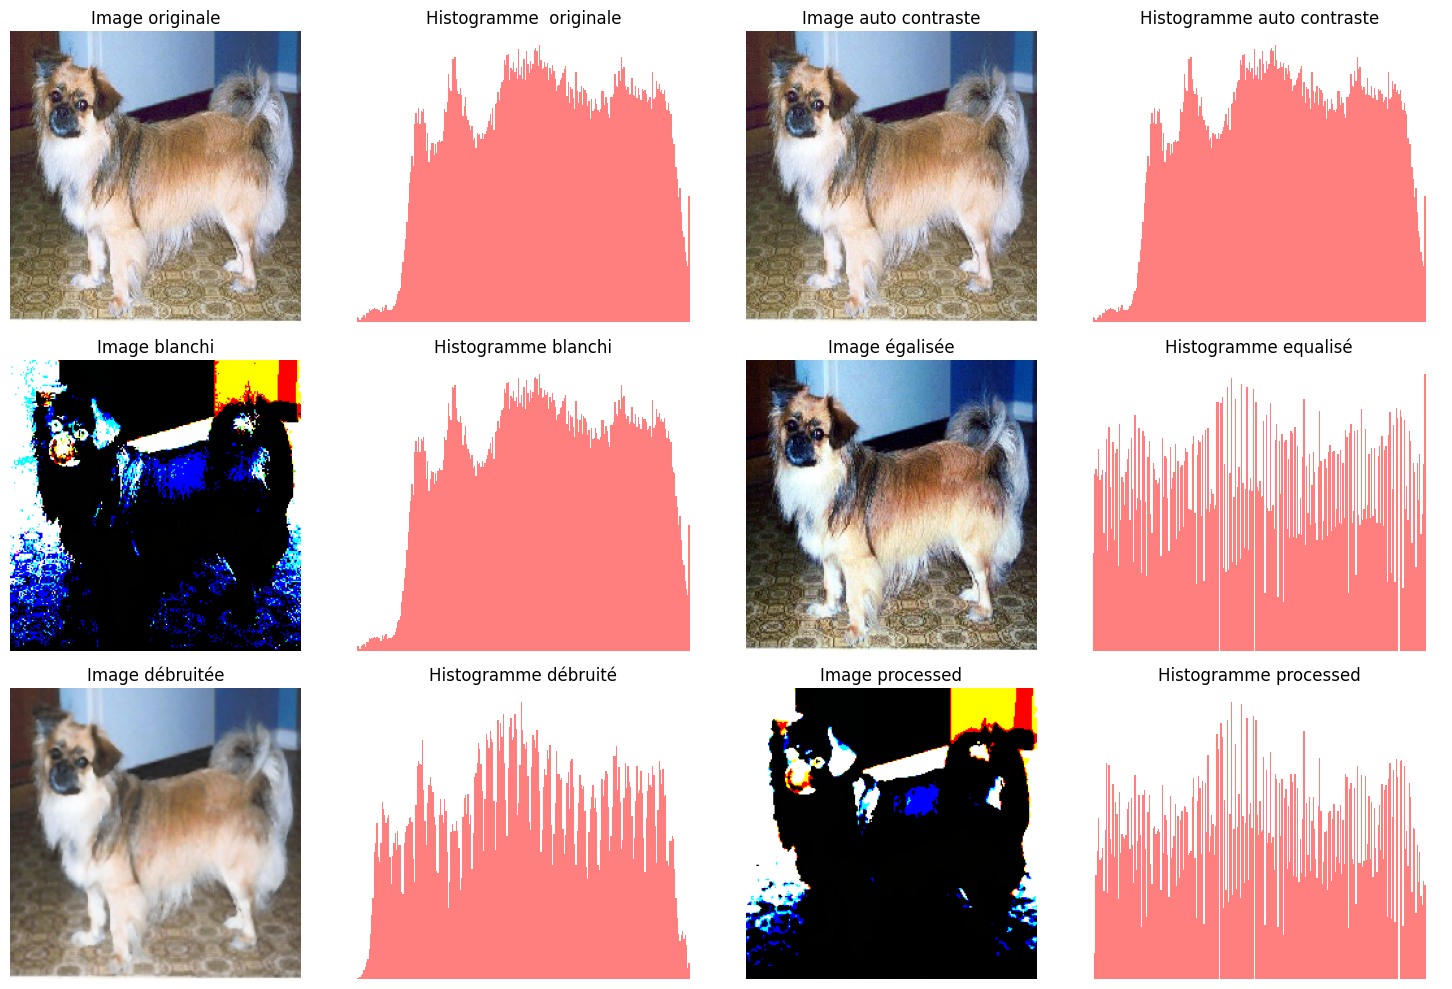

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Créer une figure avec 3x4 sous-tracés (3 lignes et 4 colonnes)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Afficher les images sur les sous-tracés
axes[0, 0].imshow(image.astype(np.uint8))
axes[0, 0].set_title("Image originale")

# Afficher les histogrammes des images
axes[0, 1].hist(image.flatten(), bins=256, color='r', alpha=0.5)
axes[0, 1].set_title("Histogramme  originale")

axes[0, 2].imshow(autocontrasted_image.numpy().astype(np.uint8))
axes[0, 2].set_title("Image auto contraste")

# Afficher les histogrammes des images
axes[0, 3].hist(autocontrasted_image.numpy().flatten(), bins=256, color='r', alpha=0.5)
axes[0, 3].set_title("Histogramme auto contraste")

axes[1, 0].imshow(whitened_image.astype(np.uint8))
axes[1, 0].set_title("Image blanchi")

# Afficher les histogrammes des images
axes[1, 1].hist(whitened_image.flatten(), bins=256, color='r', alpha=0.5)
axes[1, 1].set_title("Histogramme blanchi")

axes[1, 2].imshow(tf.cast(equalized_image, tf.uint8).numpy())
axes[1, 2].set_title("Image égalisée")

# Afficher les histogrammes des images
axes[1, 3].hist(equalized_image.numpy().flatten(), bins=256, color='r', alpha=0.5)
axes[1, 3].set_title("Histogramme equalisé")

axes[2, 0].imshow(denoised_image.astype(np.uint8))
axes[2, 0].set_title("Image débruitée")

axes[2, 1].hist(denoised_image.flatten(), bins=256, color='r', alpha=0.5)
axes[2, 1].set_title("Histogramme débruité")

axes[2, 2].imshow(processed_image.astype(np.uint8))
axes[2, 2].set_title("Image processed")

axes[2, 3].hist(processed_image.flatten(), bins=256, color='r', alpha=0.5)
axes[2, 3].set_title("Histogramme processed")


# Afficher les titres des sous-tracés
for ax in axes.flat:
    ax.axis("off")

# Ajuster les espacements entre les sous-tracés
plt.tight_layout()

# Afficher la figure
plt.show()

## 1.2 Augmentation d'image pour les entrainements

In [7]:
# Définir les transformations de data augmentation
train_data_augmentation = ImageDataGenerator(
    rotation_range=20,  # Angle de rotation aléatoire
    width_shift_range=0.2,  # Décalage horizontal aléatoire
    height_shift_range=0.2,  # Décalage vertical aléatoire
    shear_range=0.2,  # Déformation de cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retournement horizontal aléatoire
    vertical_flip=False,  # Retournement vertical aléatoire
    preprocessing_function=pretraitement_image  # Prétraitement spécifique 
)

In [8]:
# Créer un générateur de données pour le sous-ensemble de validation
validation_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

In [9]:
# Créer un générateur de données pour le sous-ensemble de tests
test_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

## 1.3 Chargement et préparation des images test et train

In [10]:
# Chemin vers le dossier contenant les images du dataset
data_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images"

In [11]:
# Définir le rapport de division entre l'entraînement et la validation
# Ici, on utilise 80% pour l'entraînement et 20% pour la validation
ratio = (0.8, 0.2)

output_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output"
remove_all_files_and_directories(output_dir)

# Diviser les images en sous-ensembles d'entraînement et de validation
splitfolders.ratio(data_dir, output=output_dir, seed=123, ratio=ratio, group_prefix=None)

# Chemin vers le dossier contenant les images d'entraînement
train_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output/train"

# Chemin vers le dossier contenant les images de validation
validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/output/val"

Copying files: 20580 files [00:52, 390.69 files/s]


In [12]:
# Chargement des images avec leurs classes
batch_size = 32
img_height, img_width = 224, 224  # Vous pouvez ajuster la taille des images selon vos besoins

# Charger les images pour l'entraînement
train_images = train_data_augmentation.flow_from_directory(
    train_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Charger les images pour la validation
validation_images = validation_data_gen.flow_from_directory(
    validation_dir,
    color_mode="rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 16418 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [13]:
# Obtenir les classes de chiens à partir de l'objet train_images
class_indices = train_images.class_indices

# Inverser le dictionnaire pour obtenir les noms de classes associés aux identifiants de classe
class_names = list(class_indices.keys())

print("Classes de chiens :", class_names[:10])

Classes de chiens : ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']


## 1.4 Chargement et préparation d'un subset des images augmentés

# 1.4.1 Création du subset images

In [14]:
# Chemin vers le dossier contenant toutes les images du dataset
data_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images"

# Définir les classes que vous souhaitez charger
selected_classes = ['n02087046-toy_terrier', 'n02091134-whippet', 'n02098413-Lhasa']

# Définir le nombre d'images par classe que vous souhaitez charger
num_images_per_class = 100

# Chemin vers le dossier où vous souhaitez sauvegarder le sous-ensemble d'images
subset_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/Images"

# Call the function to remove all files and directories
remove_all_files_and_directories(subset_dir)

# Parcourir les sous-dossiers correspondant aux classes sélectionnées
for class_name in selected_classes:
    class_dir = os.path.join(data_dir, class_name)
    subset_class_dir = os.path.join(subset_dir, class_name)

    # Créer le dossier de sortie pour la classe si celui-ci n'existe pas déjà
    os.makedirs(subset_class_dir, exist_ok=True)

    # Charger la liste des fichiers d'images dans le sous-dossier de la classe
    image_files = os.listdir(class_dir)

    # Sélectionner un nombre aléatoire d'images pour la classe
    selected_images = random.sample(image_files, num_images_per_class)

    # Copier les images sélectionnées dans le dossier de sortie pour la classe
    for image_file in selected_images:
        src_path = os.path.join(class_dir, image_file)
        dst_path = os.path.join(subset_class_dir, image_file)
        copyfile(src_path, dst_path)

# 1.4.2 Chargement et préparation par data generator

In [15]:
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir la taille des images pour le modèle
img_height, img_width = 224, 224
batch_size = 32

# Chemin vers le dossier de sortie pour le sous-ensemble
subset_output_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output"

# Call the function to remove all files and directories
remove_all_files_and_directories(subset_output_dir)

# Utiliser splitfolders pour diviser les images en ensembles d'entraînement et de validation
splitfolders.ratio(subset_dir, output=subset_output_dir, seed=123, ratio=(0.8, 0.2), group_prefix=None)        

# Chemin vers le dossier contenant les images d'entraînement
subset_train_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/train"

# Chemin vers le dossier contenant les images de validation
subset_validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/val"

# Créer un générateur de données pour le sous-ensemble d'entraînement
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=pretraitement_image
)

subset_train_images = train_data_gen.flow_from_directory(
    subset_train_dir,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Créer un générateur de données pour le sous-ensemble de validation
validation_data_gen = ImageDataGenerator(
    preprocessing_function=pretraitement_image
)

subset_validation_images = validation_data_gen.flow_from_directory(
    subset_validation_dir,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)


Copying files: 300 files [00:00, 787.06 files/s]

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [16]:
# Obtenir les classes de chiens à partir de l'objet train_images
class_indices = subset_train_images.class_indices

# Inverser le dictionnaire pour obtenir les noms de classes associés aux identifiants de classe
class_names = list(class_indices.keys())

print("Classes de chiens :", class_names)

Classes de chiens : ['n02087046-toy_terrier', 'n02091134-whippet', 'n02098413-Lhasa']


In [17]:
# Get the next batch from the data generator
batch = next(subset_train_images)

# Check the content and structure of the batch
print("Batch size:", len(batch))  # Size of the batch
#print("Batch data:", batch)       # Contents of the batch (e.g., images and labels)

Batch size: 2


In [18]:
# Chemin vers le dossier contenant les images de validation
subset_validation_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/val"

# Replace these paths with your actual directory paths
subset_test_dir = 'C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/test'

remove_all_files_and_directories(subset_test_dir)

# Create the test directory if it doesn't exist
if not os.path.exists(subset_test_dir):
    os.makedirs(subset_test_dir)
    subset_test_dir_img = os.path.join(subset_test_dir, 'img')
    os.makedirs(subset_test_dir_img)

# Traverse the subdirectories in the validation directory
for root, _, files in os.walk(subset_validation_dir):
    for image_file in files:
        src = os.path.join(root, image_file)
        dst = os.path.join(subset_test_dir_img, image_file)
        shutil.copyfile(src, dst)

print("Images copied from validation to test directory.")

The directory 'C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/sous_ensemble/output/test' does not exist.
Images copied from validation to test directory.


In [19]:
# Créer un générateur de données pour le sous-ensemble de test

subset_test_images = test_data_gen.flow_from_directory(
    subset_test_dir,
    color_mode="rgb",
    class_mode=None,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 60 images belonging to 1 classes.


In [20]:
# Get the next batch from the data generator
batch = next(subset_test_images)

# Check the content and structure of the batch
print("Batch size:", len(batch))  # Size of the batch
#print("Batch data:", batch)       # Contents of the batch (e.g., images and labels)

Batch size: 1


# 2. CNN construction

In [21]:
def plot_model_history(model_history, start_epoch, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(start_epoch, start_epoch + len(model_history.history[acc]))
    
    axs[0].plot(epochs, model_history.history[acc])
    axs[0].plot(epochs, model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(epochs, model_history.history['loss'])
    axs[1].plot(epochs, model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

## 2.1 Construction Modèle 

In [22]:
# Définir l'architecture du modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),    
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [28]:
# Définir l'architecture du modèle CNN, 10 couches à inspiration Resnet 
model2 = models.Sequential([
    layers.Conv2D(64, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),    
    layers.Conv2D(64, (3, 3), activation='relu'),    
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compiler le modèle
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Afficher un résumé du modèle
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 218, 218, 64)      9472      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 109, 109, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 107, 107, 64)      36928     
                                                                 
 conv2d_31 (Conv2D)          (None, 105, 105, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 52, 52, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 128)      

## 2.2. Entrainement  

Entrainement du modèle avec les sous ensembles images 
model.fit_generator est choisit pour utiliser les images préparées avec pretraitement et data augmentation. 

In [41]:
hist=model.fit_generator(generator = subset_train_images,
                         epochs=20,
                         validation_data=subset_validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model6.h5")
model.save(model_path)

Epoch 1/20
8/8 [==============================] - 32s 4s/step - loss: 2.8610 - accuracy: 0.3417 - val_loss: 1.0874 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 32s 4s/step - loss: 1.0851 - accuracy: 0.3375 - val_loss: 1.0876 - val_accuracy: 0.3333
Epoch 3/20
8/8 [==============================] - 30s 4s/step - loss: 1.0872 - accuracy: 0.3250 - val_loss: 1.0656 - val_accuracy: 0.3333
Epoch 4/20
8/8 [==============================] - 32s 4s/step - loss: 1.0645 - accuracy: 0.3917 - val_loss: 1.0269 - val_accuracy: 0.5667
Epoch 5/20
8/8 [==============================] - 30s 4s/step - loss: 1.0570 - accuracy: 0.4917 - val_loss: 1.0105 - val_accuracy: 0.4667
Epoch 6/20
8/8 [==============================] - 29s 4s/step - loss: 1.0260 - accuracy: 0.4792 - val_loss: 0.9966 - val_accuracy: 0.5667
Epoch 7/20
8/8 [==============================] - 29s 4s/step - loss: 0.9846 - accuracy: 0.5042 - val_loss: 0.9005 - val_accuracy: 0.6333
Epoch 8/20
8/8 [==================

In [30]:
hist2=model2.fit_generator(generator = subset_train_images,
                         epochs=20,
                         validation_data=subset_validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model11.h5")
model.save(model_path)

Epoch 1/20
8/8 [==============================] - 44s 5s/step - loss: 1.0968 - accuracy: 0.3542 - val_loss: 1.0927 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 41s 5s/step - loss: 1.0870 - accuracy: 0.3750 - val_loss: 1.0521 - val_accuracy: 0.4000
Epoch 3/20
8/8 [==============================] - 39s 5s/step - loss: 1.1138 - accuracy: 0.3875 - val_loss: 1.0786 - val_accuracy: 0.5500
Epoch 4/20
8/8 [==============================] - 40s 5s/step - loss: 1.0931 - accuracy: 0.3333 - val_loss: 1.0753 - val_accuracy: 0.4500
Epoch 5/20
8/8 [==============================] - 39s 5s/step - loss: 1.0582 - accuracy: 0.4417 - val_loss: 0.9941 - val_accuracy: 0.4833
Epoch 6/20
8/8 [==============================] - 41s 5s/step - loss: 1.0538 - accuracy: 0.4458 - val_loss: 0.9863 - val_accuracy: 0.4833
Epoch 7/20
8/8 [==============================] - 39s 5s/step - loss: 1.0134 - accuracy: 0.4500 - val_loss: 0.9474 - val_accuracy: 0.6000
Epoch 8/20
8/8 [==================

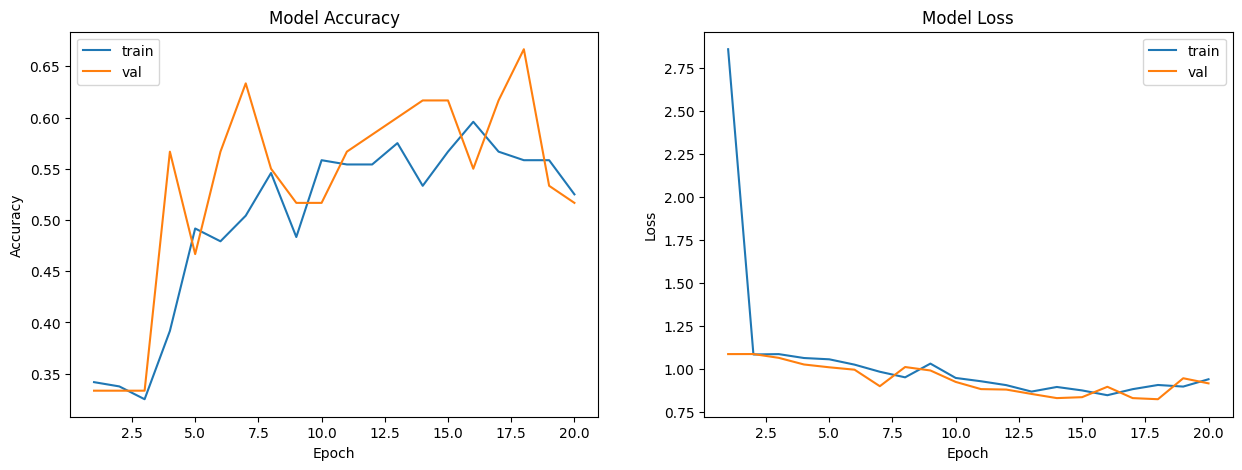

In [43]:
plot_model_history(hist, start_epoch=1)

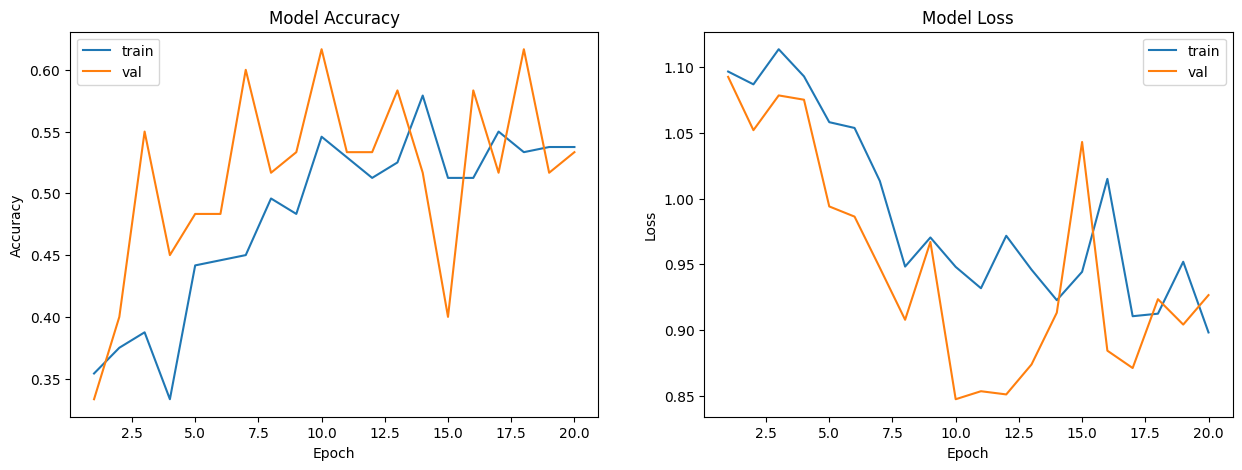

In [31]:
plot_model_history(hist2, start_epoch=1)

## 2.3 Evaluation de performance 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Culcule la matrice de confusion pour les 3 classses
def matrice_confusion(subset_train_images, subset_validation_images, y_pred_val): 

    predicted_class_indices_val = np.argmax(y_pred_val,axis=1)
    labels = (subset_train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
# Calculate the confusion matrix
    y_true = subset_validation_images.classes
    conf_matrix = confusion_matrix(y_true, predicted_class_indices_val)

# Create a list of class names (assuming the order of classes in the dictionary)
    class_names = list(labels.values())

# Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return

In [44]:
# Evaluation de performance 
loss, accuracy = model.evaluate_generator(subset_validation_images)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.516667  ;  loss = 0.917058 


In [35]:
# Evaluation de performance 2
loss2, accuracy2 = model2.evaluate_generator(subset_validation_images)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy2, loss2))

Test: accuracy = 0.533333  ;  loss = 0.926564 


In [45]:
#M1
# prediction des classes dans le subset de validation
y_pred_val =  model.predict(subset_validation_images)
matrice_confusion(subset_train_images, subset_validation_images, y_pred_val)

2/2 [==============================] - 5s 2s/step


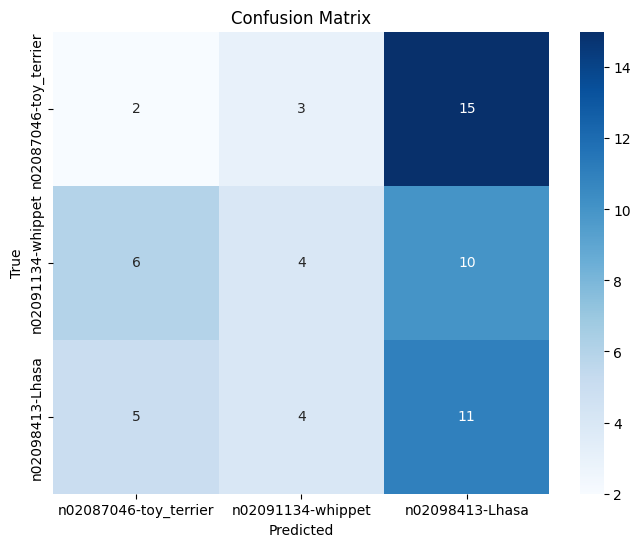

In [36]:
#M2
# prediction des classes dans le subset de validation
y_pred_val2 =  model2.predict(subset_validation_images)
matrice_confusion(subset_train_images, subset_validation_images, y_pred_val2)

## 2.4 Prédiction

In [52]:
STEP_SIZE_TEST=subset_test_images.n//subset_test_images.batch_size
subset_test_images.reset()

# prediction des classes dans le subset de tests
y_pred =  model.predict(subset_test_images)

predicted_class_indices=np.argmax(y_pred,axis=1)

labels = (subset_train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

60/60 [==============================] - 4s 65ms/step


In [28]:
filenames=subset_test_images.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [37]:
STEP_SIZE_TEST=subset_test_images.n//subset_test_images.batch_size
subset_test_images.reset()

# prediction des classes dans le subset de tests
y_pred2 =  model2.predict(subset_test_images)

predicted_class_indices2=np.argmax(y_pred2,axis=1)

labels = (subset_train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions2 = [labels[k] for k in predicted_class_indices2]

60/60 [==============================] - 4s 67ms/step


In [38]:
filenames=subset_test_images.filenames
results2=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions2})
results2.to_csv("results_M2.csv",index=False)

## 3. Hyperparamètres

## 3.1  Définir le modèle de base avec hyperparamètres

In [29]:
# Définir le modèle CNN peu profond e 6 couches, sur l'architecture VGG
def hyper_model6(filter_factor, num_epoch, num_units, optimizer):

    model = models.Sequential([
        layers.Conv2D(32*filter_factor, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(32*filter_factor, (3, 3), activation='relu'),    
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Conv2D(64*filter_factor, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Conv2D(128*filter_factor, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(num_units, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
    # Compiler le modèle
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    start_time = time.time()
    
    # entrainer le modèle
    hist=model.fit_generator(generator = subset_train_images,
                         epochs=num_epoch,
                         validation_data=subset_validation_images)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"
    
    model_name = f"model6_F{filter_factor}_U{num_units}_E{num_epoch}_O{optimizer}.h5"
    model_path = os.path.join(model_dir, model_name)
    model.save(model_path)    
    
    # evaluer le modèle
    loss, accuracy = model.evaluate_generator(subset_validation_images)
    
    resultat = ['model6',filter_factor,num_units, num_epoch, optimizer, round(loss, 4), round(accuracy, 4), round(execution_time, 0)]
    return resultat

## 3.2.  Entrainement des modèles avec combinaisons des valeurs de hyperparamètres

In [30]:
performance_list = []

In [31]:
import itertools

# Define the ranges for each hyperparameter
filter_factors = [1, 3]
num_units = [64, 256]
num_epochs = [10, 30]
optimizers = ['adam', 'rmsprop', 'sgd']

In [32]:
# Loop through all combinations of hyperparameters
for filter_factor in filter_factors:
    for num_unit in num_units:
        for num_epoch in num_epochs:
            for optimizer in optimizers:
                # Create a tuple representing the current combination
                resultat = hyper_model6(filter_factor=filter_factor, \
                        num_epoch=num_epoch, num_units=num_unit, optimizer=optimizer)
                performance_list.append(resultat)

Epoch 1/10
8/8 [==============================] - 31s 4s/step - loss: 94.5407 - accuracy: 0.2958 - val_loss: 2.0528 - val_accuracy: 0.2500
Epoch 2/10
8/8 [==============================] - 28s 3s/step - loss: 1.6985 - accuracy: 0.3375 - val_loss: 1.0751 - val_accuracy: 0.4167
Epoch 3/10
8/8 [==============================] - 28s 3s/step - loss: 1.0709 - accuracy: 0.4583 - val_loss: 1.0727 - val_accuracy: 0.4167
Epoch 4/10
8/8 [==============================] - 28s 3s/step - loss: 1.0784 - accuracy: 0.4125 - val_loss: 1.0781 - val_accuracy: 0.4667
Epoch 5/10
8/8 [==============================] - 29s 4s/step - loss: 1.0473 - accuracy: 0.4458 - val_loss: 1.0745 - val_accuracy: 0.5000
Epoch 6/10
8/8 [==============================] - 28s 3s/step - loss: 1.0372 - accuracy: 0.4875 - val_loss: 1.1035 - val_accuracy: 0.4333
Epoch 7/10
8/8 [==============================] - 29s 3s/step - loss: 1.0637 - accuracy: 0.4167 - val_loss: 1.0789 - val_accuracy: 0.4667
Epoch 8/10
8/8 [=================

8/8 [==============================] - 29s 4s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 1/10
8/8 [==============================] - 34s 4s/step - loss: 327.0647 - accuracy: 0.3625 - val_loss: 3.8330 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 29s 4s/step - loss: 1.9509 - accuracy: 0.3417 - val_loss: 1.0723 - val_accuracy: 0.3667
Epoch 3/10
8/8 [==============================] - 30s 4s/step - loss: 1.0407 - accuracy: 0.4208 - val_loss: 1.0762 - val_accuracy: 0.3500
Epoch 4/10
8/8 [==============================] - 28s 3s/step - loss: 1.0325 - accuracy: 0.4458 - val_loss: 1.0583 - val_accuracy: 0.4000
Epoch 5/10
8/8 [==============================] - 29s 3s/step - loss: 1.0207 - accuracy: 0.4625 - val_loss: 1.0741 - val_accuracy: 0.4333
Epoch 6/10
8/8 [==============================] - 31s 4s/step - loss: 1.0499 - accuracy: 0.4500 - val_loss: 1.0682 - val_accuracy: 0.4333
Epoch 7/10
8/8 [==============================] -

Epoch 30/30
8/8 [==============================] - 31s 4s/step - loss: 0.9887 - accuracy: 0.4875 - val_loss: 1.1361 - val_accuracy: 0.4167
Epoch 1/30
8/8 [==============================] - 43s 5s/step - loss: 562.6436 - accuracy: 0.3208 - val_loss: 5.2914 - val_accuracy: 0.3000
Epoch 2/30
8/8 [==============================] - 35s 5s/step - loss: 2.9747 - accuracy: 0.3167 - val_loss: 1.0956 - val_accuracy: 0.5167
Epoch 3/30
8/8 [==============================] - 35s 4s/step - loss: 1.1179 - accuracy: 0.4208 - val_loss: 1.1017 - val_accuracy: 0.4667
Epoch 4/30
8/8 [==============================] - 29s 4s/step - loss: 1.0759 - accuracy: 0.4625 - val_loss: 0.9924 - val_accuracy: 0.5167
Epoch 5/30
8/8 [==============================] - 31s 4s/step - loss: 1.1766 - accuracy: 0.5250 - val_loss: 1.2339 - val_accuracy: 0.3333
Epoch 6/30
8/8 [==============================] - 29s 4s/step - loss: 1.7678 - accuracy: 0.5167 - val_loss: 8.2676 - val_accuracy: 0.3333
Epoch 7/30
8/8 [===============

8/8 [==============================] - 78s 10s/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 30/30
8/8 [==============================] - 78s 10s/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 1/30
8/8 [==============================] - 84s 10s/step - loss: 2289.8052 - accuracy: 0.3417 - val_loss: 25.5709 - val_accuracy: 0.3333
Epoch 2/30
8/8 [==============================] - 79s 10s/step - loss: 6.2841 - accuracy: 0.3083 - val_loss: 1.0826 - val_accuracy: 0.3833
Epoch 3/30
8/8 [==============================] - 79s 10s/step - loss: 1.0804 - accuracy: 0.3458 - val_loss: 1.0859 - val_accuracy: 0.3333
Epoch 4/30
8/8 [==============================] - 80s 10s/step - loss: 1.0923 - accuracy: 0.3583 - val_loss: 1.0955 - val_accuracy: 0.3500
Epoch 5/30
8/8 [==============================] - 78s 10s/step - loss: 1.0790 - accuracy: 0.4000 - val_loss: 1.1776 - val_accuracy: 0.3333
Epoch 6/30
8/8 [=================

Epoch 29/30
8/8 [==============================] - 74s 9s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 30/30
8/8 [==============================] - 76s 9s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 1/10
8/8 [==============================] - 82s 10s/step - loss: 990.7281 - accuracy: 0.3250 - val_loss: 8.0476 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 79s 10s/step - loss: 3.9058 - accuracy: 0.3500 - val_loss: 1.9947 - val_accuracy: 0.3333
Epoch 3/10
8/8 [==============================] - 79s 10s/step - loss: 1.4964 - accuracy: 0.4000 - val_loss: 1.1576 - val_accuracy: 0.3333
Epoch 4/10
8/8 [==============================] - 78s 10s/step - loss: 1.0988 - accuracy: 0.3917 - val_loss: 1.1019 - val_accuracy: 0.3500
Epoch 5/10
8/8 [==============================] - 78s 10s/step - loss: 1.3239 - accuracy: 0.3333 - val_loss: 1.1023 - val_accuracy: 0.3500
Epoch 6/10
8/8 [=====================

8/8 [==============================] - 78s 10s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 29/30
8/8 [==============================] - 78s 10s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333
Epoch 30/30
8/8 [==============================] - 79s 10s/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3333


In [33]:
hyper_performance = pd.DataFrame(performance_list, columns=['Modele', 'filter_factor', \
                'num_units', 'num_epoch', 'optimizer', 'loss', 'accuracy', 'duration(s)'])
hyper_performance.to_csv('hyper_performance.csv')

# 4.  Transfer learning

## 4.1 Chargement de modèle pré entrainé

In [59]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Chemin vers le dossier contenant les images du Stanford Dogs Dataset
data_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/Images"

# Charger le modèle pré-entraîné VGG16 sans la dernière couche (inclut_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

## 4.2   Stratégie de transfer learning

In [60]:
# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter de couches dense pour la classification des races de chiens
model_tl1 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes de races de chiens notre subset
])

# Compiler le modèle
model_tl1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model_tl1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


## 4.3 entrainement de modèle avec subset

In [76]:
hist=model_tl1.fit_generator(generator = subset_train_images,
                         epochs=10,
                         validation_data=subset_validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model_tl1_sub.h5")
model_tl1.save(model_path)

Epoch 1/10
8/8 [==============================] - 51s 6s/step - loss: 0.2035 - accuracy: 0.9167 - val_loss: 0.4836 - val_accuracy: 0.8333
Epoch 2/10
8/8 [==============================] - 49s 6s/step - loss: 0.1722 - accuracy: 0.9292 - val_loss: 0.3650 - val_accuracy: 0.8667
Epoch 3/10
8/8 [==============================] - 51s 6s/step - loss: 0.1672 - accuracy: 0.9458 - val_loss: 0.4527 - val_accuracy: 0.8500
Epoch 4/10
8/8 [==============================] - 48s 6s/step - loss: 0.1680 - accuracy: 0.9375 - val_loss: 0.3919 - val_accuracy: 0.8500
Epoch 5/10
8/8 [==============================] - 48s 6s/step - loss: 0.1529 - accuracy: 0.9542 - val_loss: 0.3746 - val_accuracy: 0.8667
Epoch 6/10
8/8 [==============================] - 47s 6s/step - loss: 0.1424 - accuracy: 0.9417 - val_loss: 0.3866 - val_accuracy: 0.8667
Epoch 7/10
8/8 [==============================] - 51s 6s/step - loss: 0.2484 - accuracy: 0.8958 - val_loss: 0.3660 - val_accuracy: 0.8667
Epoch 8/10
8/8 [==================

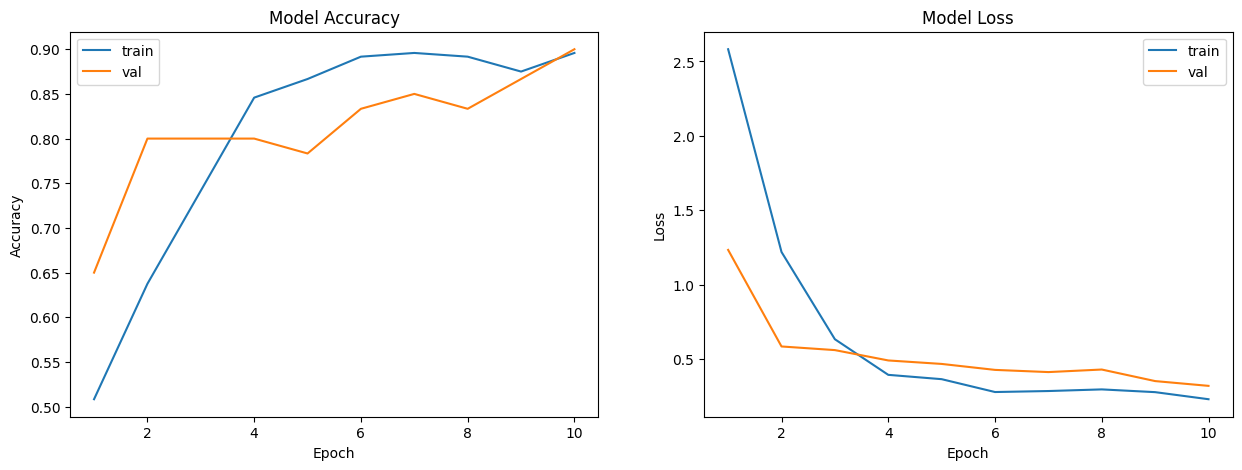

In [68]:
plot_model_history(hist, start_epoch=1)

In [91]:
# prediction des classes dans le subset de validation
model_path = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models/model_tl1_sub.h5"
model_tl1 = load_model(model_path)

y_pred_val =  model_tl1.predict_generator(subset_validation_images)
predicted_class_indices_val=np.argmax(y_pred_val,axis=1)

labels = (subset_train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

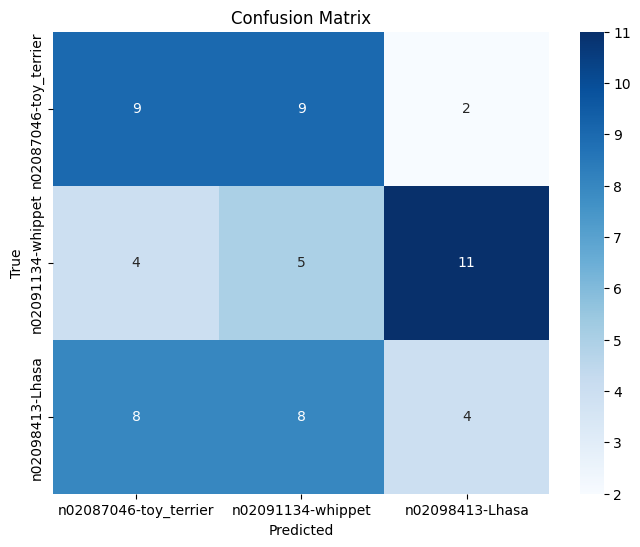

In [93]:
# Culcule la matrice de confusion pour les 3 classses

y_true = subset_validation_images.classes
conf_matrix = confusion_matrix(y_true, predicted_class_indices_val)

# Create a list of class names (assuming the order of classes in the dictionary)
class_names = list(labels.values())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [84]:
# prediction des classes dans le subset de tests
y_pred =  model_tl1.predict(subset_test_images)

predicted_class_indices=np.argmax(y_pred,axis=1)

labels = (subset_train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=subset_test_images.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_tl.csv",index=False)

60/60 [==============================] - 9s 148ms/step


## 4.4. Entrainement de modèle avec full set 

In [39]:
# Ajouter de couches dense pour la classification des races de chiens
model_tl2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 classes de races 
])

# Compiler le modèle
model_tl2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model_tl2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_26 (Flatten)        (None, 25088)             0         
                                                                 
 dense_52 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 120)               30840     
                                                                 
Total params: 21,168,312
Trainable params: 6,453,624
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
hist=model_tl2.fit_generator(generator = train_images,
                         epochs=10,
                         validation_data=validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model_tl2_full.h5")
model.save(model_path)

Epoch 1/10
514/514 [==============================] - 3143s 6s/step - loss: 5.6685 - accuracy: 0.0116 - val_loss: 4.7855 - val_accuracy: 0.0125
Epoch 2/10
514/514 [==============================] - 2748s 5s/step - loss: 4.7856 - accuracy: 0.0122 - val_loss: 4.7832 - val_accuracy: 0.0123
Epoch 3/10
514/514 [==============================] - 2845s 6s/step - loss: 4.7878 - accuracy: 0.0121 - val_loss: 4.7820 - val_accuracy: 0.0123
Epoch 4/10
514/514 [==============================] - 2887s 6s/step - loss: 4.7818 - accuracy: 0.0119 - val_loss: 4.8399 - val_accuracy: 0.0123
Epoch 5/10
514/514 [==============================] - 3174s 6s/step - loss: 4.7845 - accuracy: 0.0122 - val_loss: 4.7794 - val_accuracy: 0.0123
Epoch 6/10
514/514 [==============================] - 2971s 6s/step - loss: 4.7802 - accuracy: 0.0122 - val_loss: 4.7794 - val_accuracy: 0.0123
Epoch 7/10
514/514 [==============================] - 2995s 6s/step - loss: 4.7831 - accuracy: 0.0122 - val_loss: 4.7793 - val_accuracy:

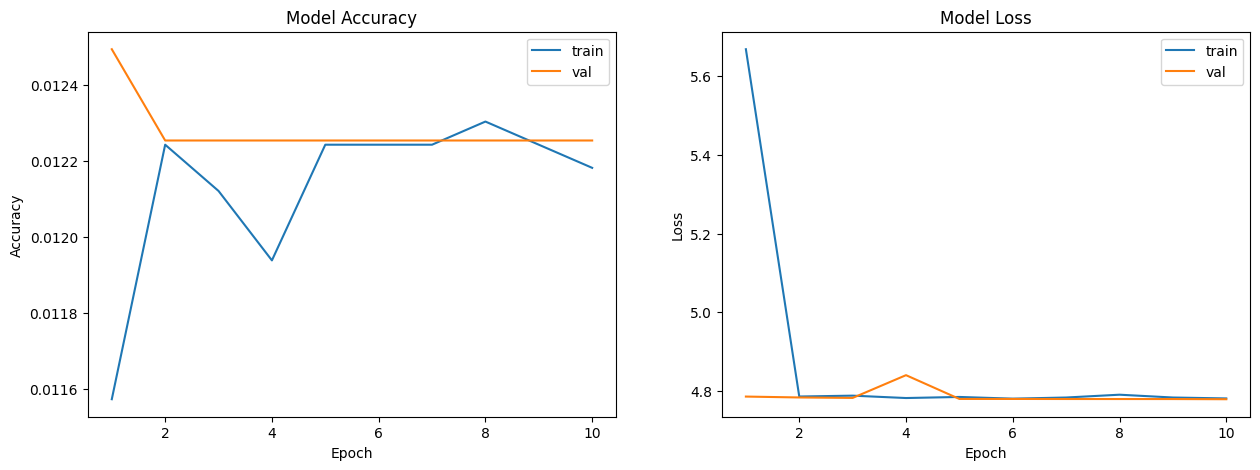

In [41]:
plot_model_history(hist, start_epoch=1)

In [43]:
# Ajouter de couches dense pour la classification des races de chiens
model_tl3 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1200, activation='relu'),
#    layers.Dropout(0.5),
    layers.Dense(120, activation='softmax')  # 120 classes de races 
])

# Compiler le modèle
model_tl3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model_tl3.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_27 (Flatten)        (None, 25088)             0         
                                                                 
 dense_54 (Dense)            (None, 1200)              30106800  
                                                                 
 dense_55 (Dense)            (None, 120)               144120    
                                                                 
Total params: 44,965,608
Trainable params: 44,965,608
Non-trainable params: 0
_________________________________________________________________


In [44]:
hist3=model_tl3.fit_generator(generator = train_images,
                         epochs=5,
                         validation_data=validation_images)
model_dir = "C:/Users/utilisateur/OneDrive/Document/Trading/ML/Projet6/data/images/models"

model_path = os.path.join(model_dir, "model_tl3_full.h5")
model.save(model_path)

Epoch 1/5
514/514 [==============================] - 8994s 17s/step - loss: 5.4960 - accuracy: 0.0106 - val_loss: 4.7776 - val_accuracy: 0.0118
Epoch 2/5
514/514 [==============================] - 8507s 17s/step - loss: 4.7822 - accuracy: 0.0116 - val_loss: 4.7797 - val_accuracy: 0.0123
Epoch 3/5
514/514 [==============================] - 8871s 17s/step - loss: 4.7821 - accuracy: 0.0116 - val_loss: 4.7795 - val_accuracy: 0.0123
Epoch 4/5
514/514 [==============================] - 8710s 17s/step - loss: 4.7815 - accuracy: 0.0118 - val_loss: 4.7793 - val_accuracy: 0.0123
Epoch 5/5
514/514 [==============================] - 7808s 15s/step - loss: 4.7813 - accuracy: 0.0122 - val_loss: 4.7792 - val_accuracy: 0.0123


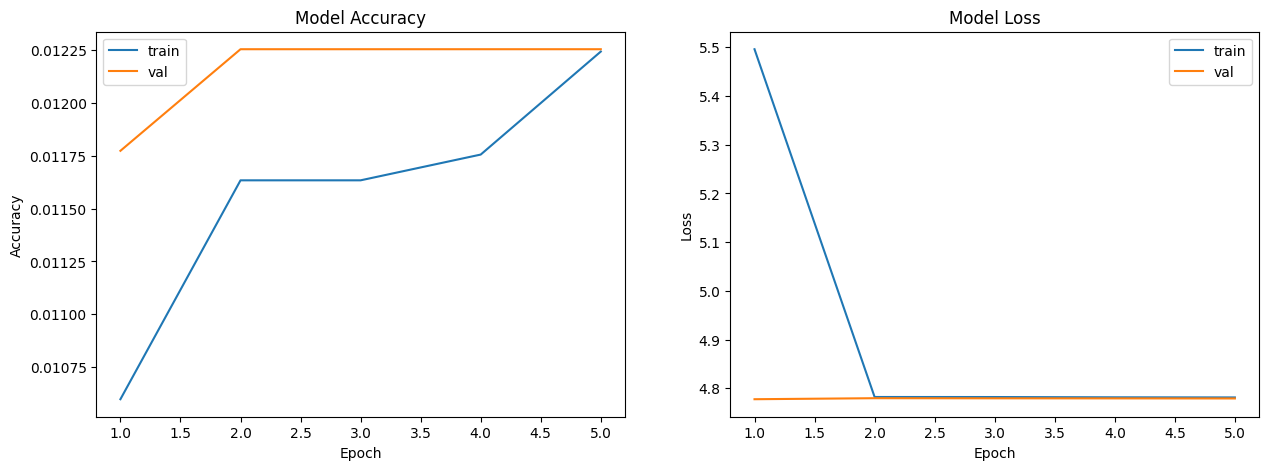

In [45]:
plot_model_history(hist3, start_epoch=1)

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

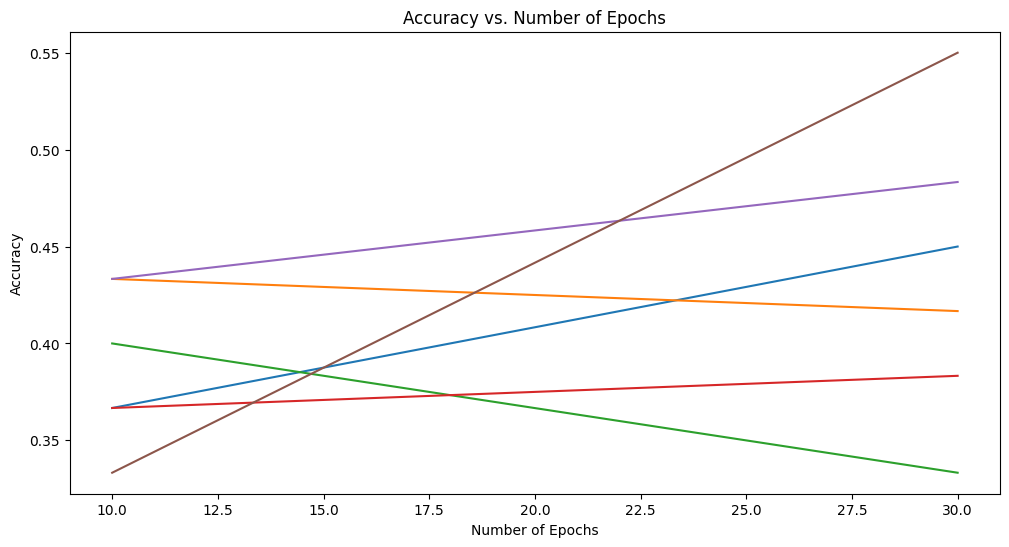

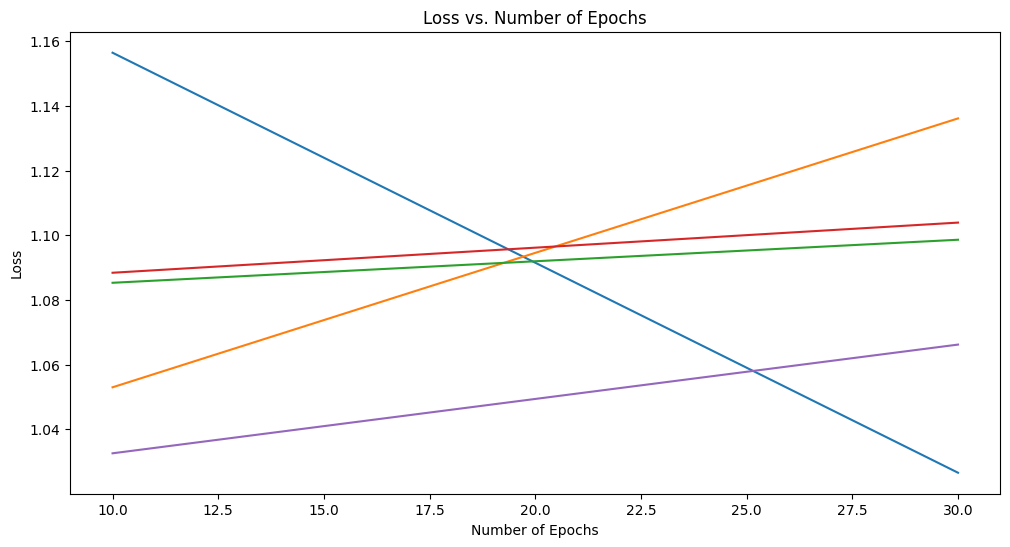

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Given performance data
performance_data = {
    'optimizer': ['adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'adam', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop', 'rmsprop'],
    'filter_factor': [1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3],
    'num_units': [64, 64, 256, 256, 64, 64, 256, 256, 64, 64, 256, 256, 64, 64, 256, 256],
    'num_epochs': [10, 30, 10, 30, 10, 30, 10, 30, 10, 30, 10, 30, 10, 30, 10, 30],
    'loss': [1.1564, 1.0266, 1.053, 1.1361, 1.0853, 1.0986, 1.0884, 1.1039, 1.0326, 1.0662, 20.8895, 1.1096, 1.0912, 1.0986, 80.1821, 1.0934],
    'accuracy': [0.3667, 0.45, 0.4333, 0.4167, 0.4, 0.3333, 0.3667, 0.3833, 0.4333, 0.4833, 0.3333, 0.55, 0.4, 0.3333, 0.3333, 0.3333],
    'duration': [294, 870, 300, 911, 812, 2477, 789, 2392, 298, 832, 306, 942, 874, 2497, 788, 2342]
}

# Extract unique values for each parameter
optimizers = np.unique(performance_data['optimizer'])
filter_factors = np.unique(performance_data['filter_factor'])
num_units = np.unique(performance_data['num_units'])
num_epochs = np.unique(performance_data['num_epochs'])

# Create a figure for accuracy
fig_accuracy, ax_accuracy = plt.subplots(figsize=(12, 6))
ax_accuracy.set_xlabel('Number of Epochs')
ax_accuracy.set_ylabel('Accuracy')
ax_accuracy.set_title('Accuracy vs. Number of Epochs')

# Create a figure for loss
fig_loss, ax_loss = plt.subplots(figsize=(12, 6))
ax_loss.set_xlabel('Number of Epochs')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss vs. Number of Epochs')

for optimizer in optimizers:
    for filter_factor in filter_factors:
        for num_unit in num_units:
            accuracy_vals = []
            loss_vals = []
            num_epochs_vals = []
            
            for index, opt in enumerate(performance_data['optimizer']):
                factor = performance_data['filter_factor'][index]
                unit = performance_data['num_units'][index]
                loss = performance_data['loss'][index]
                
                if opt == optimizer and factor == filter_factor and unit == num_unit:
                    accuracy_vals.append(performance_data['accuracy'][index])
                    num_epochs_vals.append(performance_data['num_epochs'][index])
                    
                    if loss <= 20:  # Discard loss values greater than 20
                        loss_vals.append(loss)
            
            if len(accuracy_vals) > 0:
                ax_accuracy.plot(num_epochs_vals, accuracy_vals, label=f"{optimizer}, filter={filter_factor}, units={num_unit}")
            
            if len(loss_vals) > 0:
                ax_loss.plot(num_epochs_vals, loss_vals, label=f"{optimizer}, filter={filter_factor}, units={num_unit}")

# Show legends for both figures
ax_accuracy.legend()
ax_loss.legend()

# Show the figures
plt.show()
